# Recognition of self-initiated emotional expressions using facial electromyography

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import scipy.signal
from scipy.fft import fft, fftfreq
from scipy import stats

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from yellowbrick.classifier import ClassificationReport

Constants initiation

In [2]:
TRIAL_TIME = 3 # in seconds
TRIALS_AMOUNT = 30 
SAMPLE_RATE = 500
N_ELECTRODES = 8

TRIAL_SAMPLES = TRIAL_TIME * SAMPLE_RATE

In [3]:
emotions = ['neutral', 'anger', 'disgust', 
            'fear', 'sadness', 'happiness', 
            'surprise', 'anxiety', 'contempt',
            'delight', 'perplexity', 'pride']

columns_names = []
for feature in ['max_amp', 'mean_amp', 'freq', 'freq_sec']:
    for electrode_i in range(1, 9):
        name = f'el_{electrode_i}_{feature}'
        columns_names.append(name)
        
columns_names.append('emotion')

In [4]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

In [5]:
def make_df_by_index(subject, electrodes=[0, 1, 2, 3, 4, 5, 6, 7]):
    
    df_resulted = pd.DataFrame(columns=columns_names)
    
    for emotion in range(len(emotions)):
        
        df_emotion = pd.DataFrame(columns=columns_names)
        
        data = np.load(f'data/{emotions[emotion]}/{emotions[emotion]}_{subject}.npy')
        
        for electrode in range(N_ELECTRODES):
            if electrode in electrodes:
                el = data[:, electrode]
                el = el[el != -1000]

                amplitudes = []
                mean_amp = []
                frequencies_first = []
                frequencies_second = []

                for bound in range(TRIAL_SAMPLES, TRIAL_SAMPLES * TRIALS_AMOUNT + 1, TRIAL_SAMPLES):
                    
                    sample_raw = el[bound-TRIAL_SAMPLES:bound]
                    sample = butter_highpass_filter(sample_raw, 15, SAMPLE_RATE, order=5)
                    
                    sample_filt = scipy.signal.savgol_filter(abs(sample), 249, 2)
                    
                    yf = fft(sample)
                    xf = fftfreq(sample_filt.shape[0], 1 / SAMPLE_RATE)
                    indexes = np.argsort(np.abs(yf))[::-1]
                    
                    freq_1 = abs(xf[indexes[1]])
                    freq_2 = abs(xf[indexes[3]])

                    amplitudes.append(max(sample_filt) * 1000)
                    mean_amp.append(np.mean(sample_filt) * 1000)
                    
                    frequencies_first.append(freq_1)
                    frequencies_second.append(freq_1)

                df_emotion[columns_names[electrode]] = amplitudes
                df_emotion[columns_names[electrode + 8]] = mean_amp
                df_emotion[columns_names[electrode + 16]] = frequencies_first
                df_emotion[columns_names[electrode + 24]] = frequencies_second

        
        df_emotion['emotion'] = np.repeat(emotion, len(amplitudes))
        df_resulted = pd.concat([df_resulted, df_emotion], ignore_index=True)
        
    df_resulted['emotion'] = df_resulted['emotion'].astype('int')
            
    return df_resulted

Upload data using custom function

In [6]:
df_first = make_df_by_index(1).dropna(axis=1)

In [7]:
dfs = []

for i in range(1, 11):
    data = make_df_by_index(i).dropna(axis=1)
    dfs.append(data)

In [8]:
df_overall = pd.concat(dfs, ignore_index=True)
df_overall = df_overall.dropna(axis=1)

From here onwards I use Random Forest as a primary classificator, choose any other if you like

# Train between subjects

Here we take only one participant at a time in test sample, so they aren't included in the training data.

In [9]:
precision_matrix = np.zeros(10)
f1_matrix = np.zeros(10)
recall_matrix = np.zeros(10)

In [10]:
for row in range(precision_matrix.shape[0]):
    counter = 0
    df_train = pd.DataFrame(columns=columns_names)
    df_test = pd.DataFrame(columns=columns_names)

    for df in dfs:
        
        labels = df['emotion'].astype('int')
        df = df.drop('emotion', axis=1)
        df = stats.zscore(df, axis=0)
        df['emotion'] = labels

        if counter == row:
            df_test = pd.concat([df_test, df], ignore_index=True)
        else:
            df_train = pd.concat([df_train, df], ignore_index=True)
        counter += 1

    df_test = df_test.dropna(axis=1)
    df_train = df_train.dropna(axis=1)

    features_train = df_train.drop('emotion', axis=1)
    features_valid = df_test.drop('emotion', axis=1)
    
    target_train = df_train['emotion'].astype('int')
    target_valid = df_test['emotion'].astype('int')

    model = RandomForestClassifier(random_state=123)
    model = model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    precision_matrix[row] = precision_score(target_valid, predicted_valid, average='weighted')
    f1_matrix[row] = f1_score(target_valid, predicted_valid, average='weighted')
    recall_matrix[row] = recall_score(target_valid, predicted_valid, average='weighted')

c:\users\vlvdi\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
score_matrix = np.zeros([4, 10])

In [12]:
score_matrix[0, :] = np.arange(1, 11).astype(int)
score_matrix[1, :] = precision_matrix
score_matrix[2, :] = f1_matrix
score_matrix[3, :] = recall_matrix

In [13]:
scores = pd.DataFrame(score_matrix, index=['Subject ID', 'Accuracy', 'Recall', 'F1'])

In [14]:
scores

,0,1,2,3,4,5,6,7,8,9
Subject ID,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
Accuracy,0.379099,0.326005,0.286868,0.354747,0.157187,0.277913,0.308142,0.307814,0.305186,0.390137
Recall,0.388083,0.322946,0.249420,0.336260,0.151621,0.287799,0.248281,0.282753,0.266023,0.247971
F1,0.416667,0.350000,0.266667,0.352778,0.186111,0.311111,0.275000,0.286111,0.261111,0.302778


### For 2 subjects in test sample

In [15]:
id_matrix = np.zeros((10, 10))

In [16]:
id_was = []

for row in range(id_matrix.shape[0]):
    for col in range(id_matrix.shape[1]):
        
        if sorted([row, col]) in id_was:
            id_matrix[row, col] = id_matrix[col, row]
        else: 
            counter = 0
            df_train = pd.DataFrame(columns=columns_names)
            df_test = pd.DataFrame(columns=columns_names)

            for df in dfs:
                if (counter == row) or (counter == col):
                    df_test = pd.concat([df_test, df], ignore_index=True)
                else:
                    df_train = pd.concat([df_train, df], ignore_index=True)
                counter += 1
            
            df_test = df_test.dropna(axis=1)
            df_train = df_train.dropna(axis=1)
            
            features_train = df_train.drop('emotion', axis=1)
            features_valid = df_test.drop('emotion', axis=1)
            target_train = df_train['emotion'].astype('int')
            target_valid = df_test['emotion'].astype('int')

            model = RandomForestClassifier(random_state=123)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            id_matrix[row, col] = precision_score(target_valid, predicted_valid, average='micro')

            id_was.append([row, col])

Intersection at the figure below - IDs of participants who were included in test sample

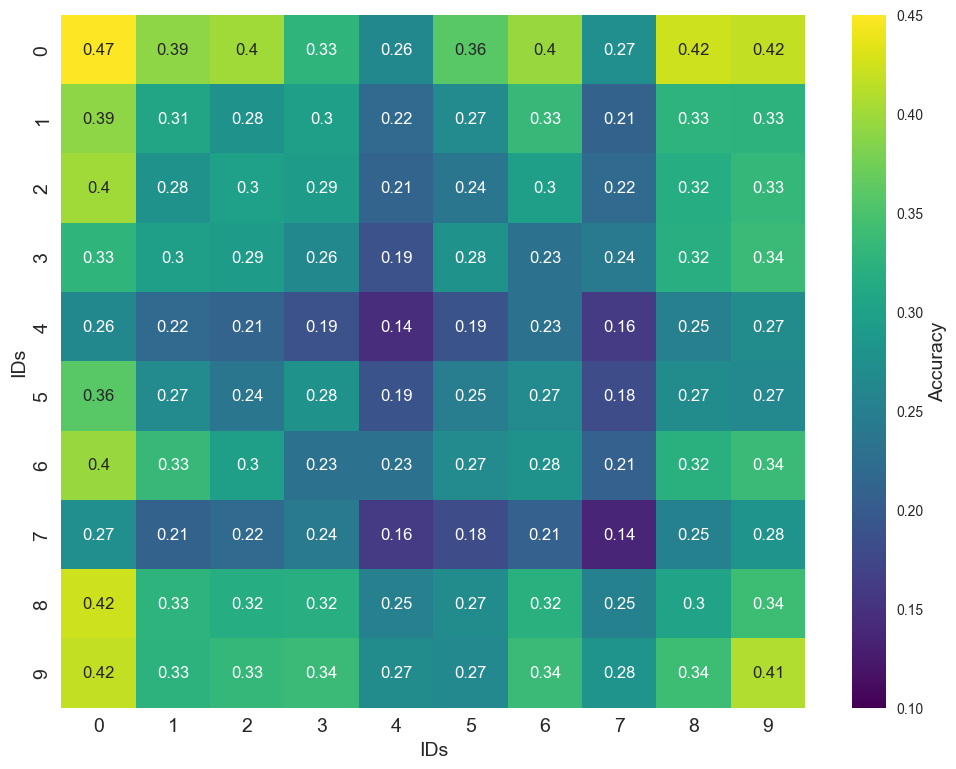

In [17]:
palette = sns.color_palette("viridis", as_cmap=True)
ax = sns.heatmap(id_matrix, cmap='viridis', vmin=0.10, vmax=0.45, annot=True, cbar_kws={'label': 'Accuracy'})
ax.tick_params(axis='both', which='major', labelsize=14)
ax.figure.axes[-1].yaxis.label.set_size(14)
plt.xlabel('IDs', size=14)
plt.ylabel('IDs', size=14)

fig = plt.gcf()
fig.set_size_inches(12, 9)

In [18]:
print('mean:', np.round(id_matrix.mean(), 2), 'std:', np.round(id_matrix.std(), 2))

mean: 0.29 std: 0.07


# Train and test inside one person

In [19]:
print('Precision:')
for df_i in range(len(dfs)):
    df = dfs[df_i]
    df = df.dropna(axis=1)
    target = df['emotion']
    features = df.drop('emotion', axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=123)
    
    model = RandomForestClassifier(random_state=123)
    model = model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    precision = np.round(precision_score(target_valid, predicted_valid, average='micro'), 2)
    
    print(f'{precision} for {df_i + 1} participant')

Precision:
0.97 for 1 participant
0.81 for 2 participant
0.91 for 3 participant
0.87 for 4 participant
0.56 for 5 participant
0.8 for 6 participant
0.86 for 7 participant
0.78 for 8 participant
0.92 for 9 participant
0.91 for 10 participant


# Train with randomly sampled data

In [20]:
target = df_overall['emotion']
features = df_overall.drop('emotion', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=0)

## Decision Tree

In [21]:
model = DecisionTreeClassifier(random_state=15)
model = model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Average precision:',np.round(precision_score(target_valid, predicted_valid, average='micro'), 2))

Average precision: 0.63


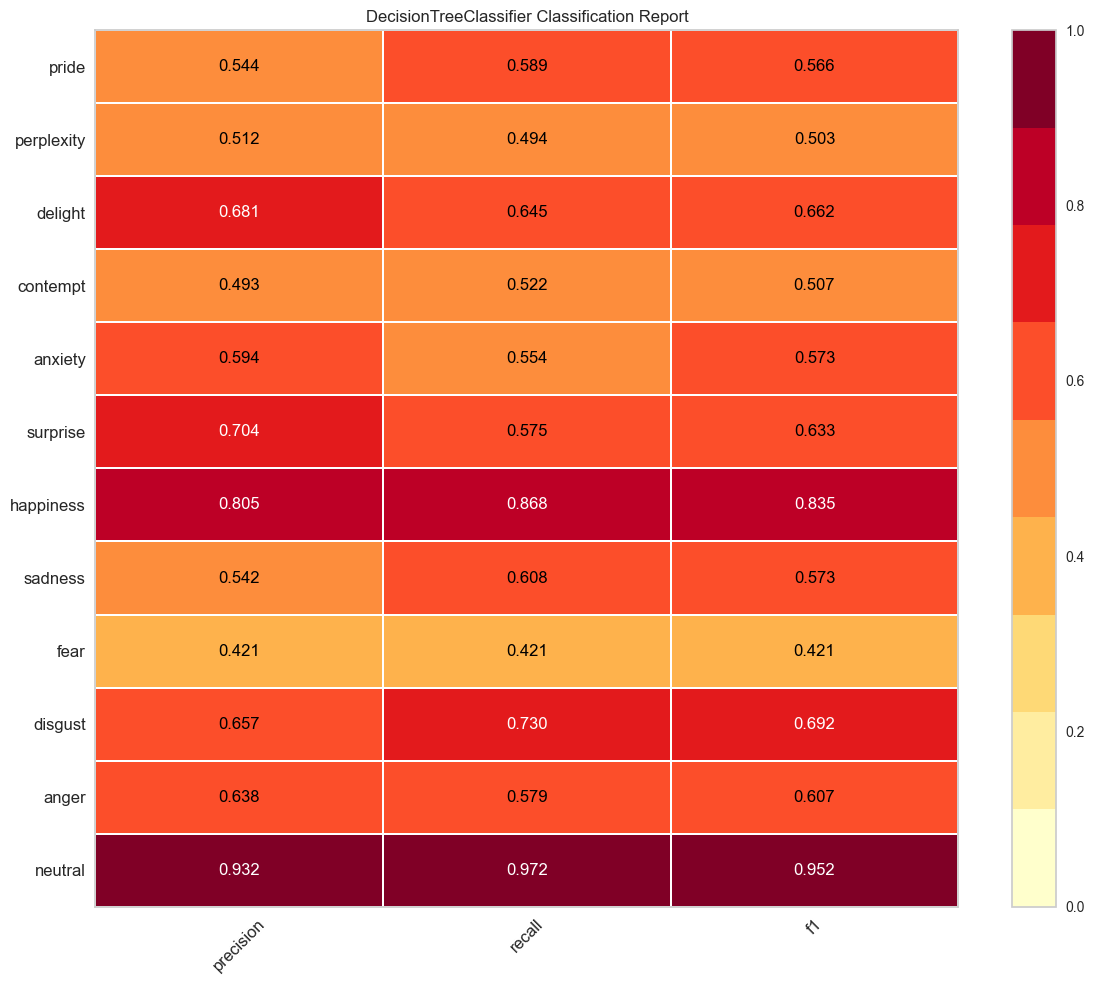

In [22]:
viz = ClassificationReport(DecisionTreeClassifier(random_state=12),
                           support=False,
                           classes=emotions,
                           fig=plt.figure(figsize=(12,10)))

viz.fit(features_train, target_train)

viz.score(features_valid, target_valid)

viz.show();

## Random Forest

In [23]:
model = RandomForestClassifier(random_state=3)
model = model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Average precision:',np.round(precision_score(target_valid, predicted_valid, average='micro'), 2))

Average precision: 0.81


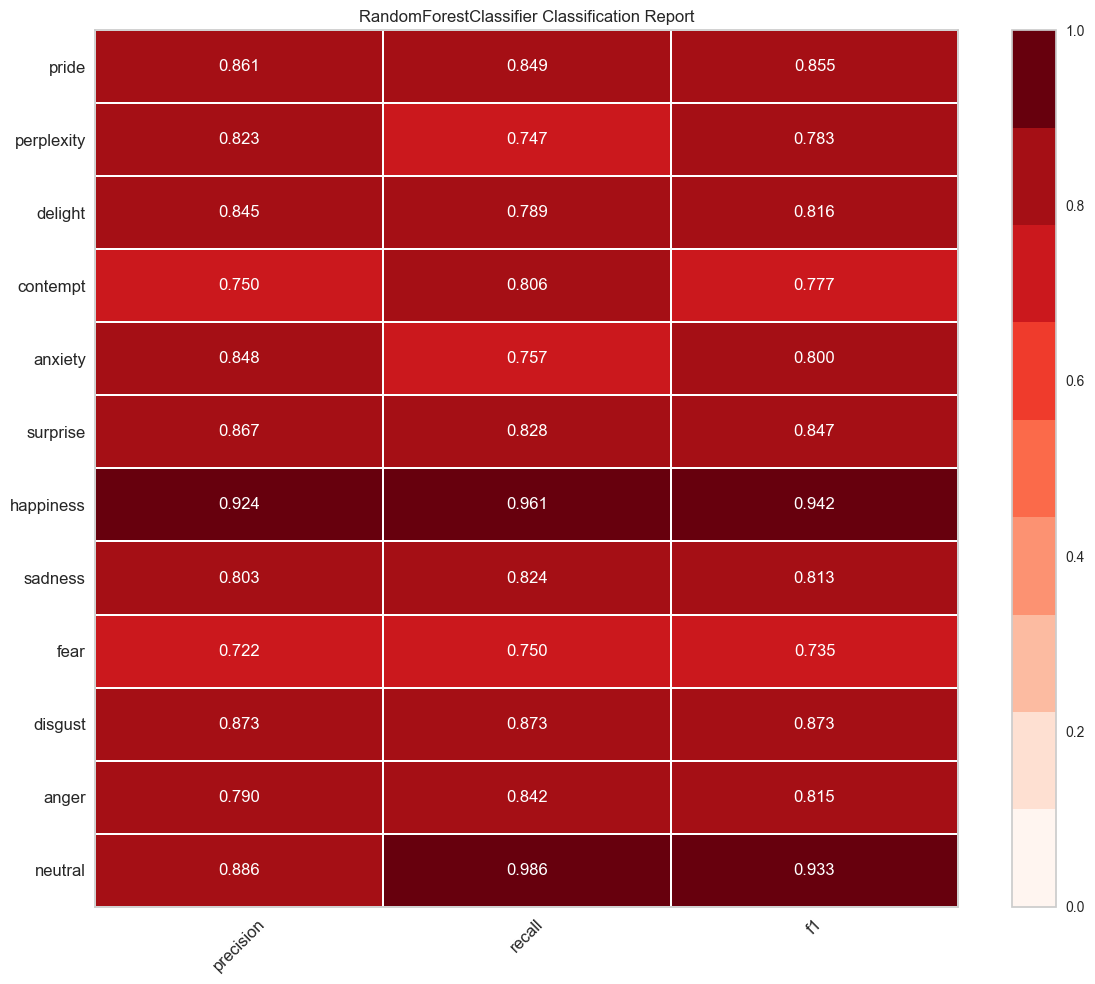

In [24]:
viz = ClassificationReport(RandomForestClassifier(random_state=8, bootstrap=False), support=False,
                           classes=emotions, fig=plt.figure(figsize=(12,10)), cmap='Reds')

viz.fit(features_train, target_train)

viz.score(features_valid, target_valid)
viz.show();


## Gradient Boosting

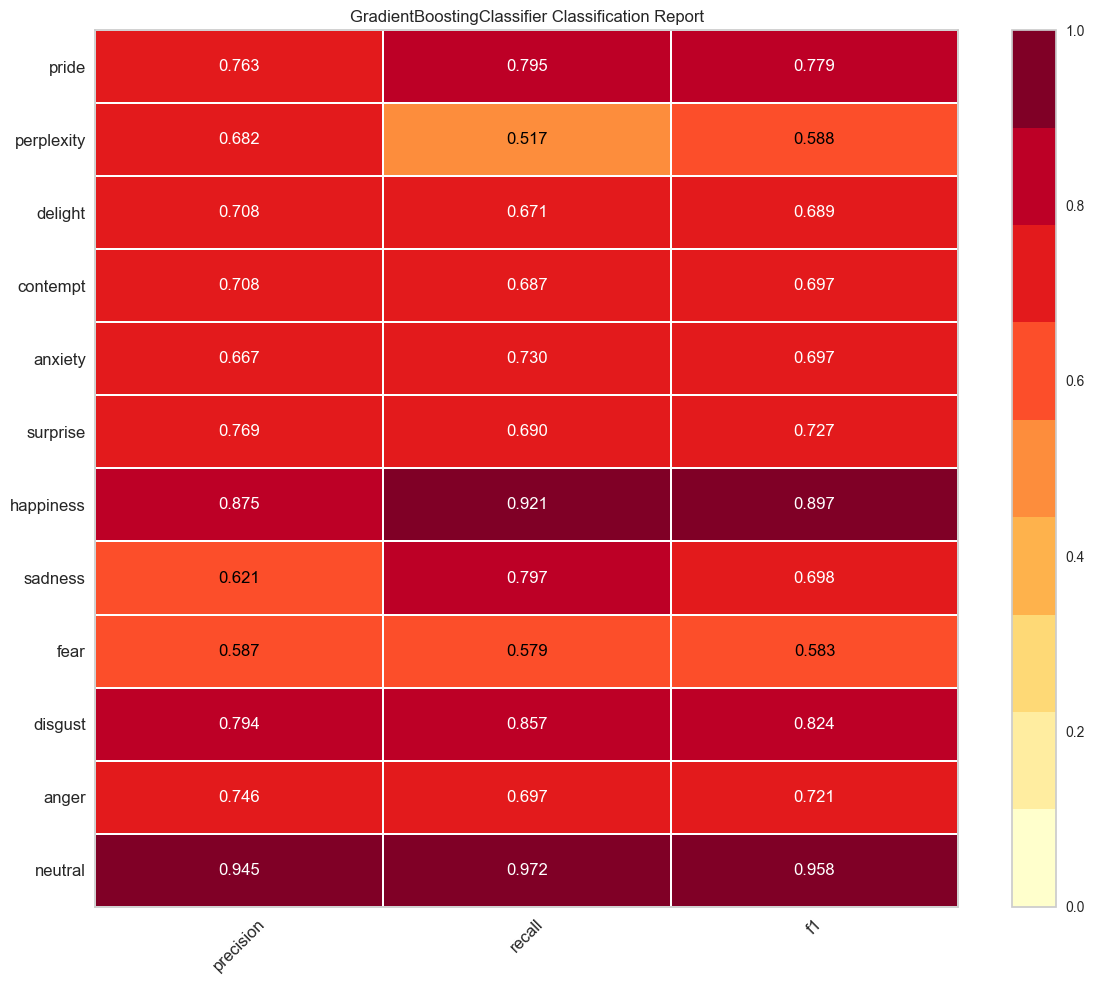

In [25]:
viz = ClassificationReport(GradientBoostingClassifier(random_state=8),
                           support=False,
                           classes=emotions,
                           fig=plt.figure(figsize=(12,10))) #, cmap='RdBu')

viz.fit(features_train, target_train)

viz.score(features_valid, target_valid)

viz.show();

## Dummy classifier

In [26]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
predicted_valid = dummy_clf.predict(features_valid)
print('Average precision:',np.round(precision_score(target_valid, predicted_valid, average='micro'), 2))

Average precision: 0.07


# Electrodes analysis

Here we look at pairs of electrodes (locations) and accuracies if we train our models based on these locations

In [27]:
el_matrix = np.zeros((8, 8))

In [28]:
was = []

for row in range(el_matrix.shape[0]):
    for col in range(el_matrix.shape[1]):
        
        if sorted([row, col]) in was:
            el_matrix[row, col] = el_matrix[col, row]
        else:
            general_set = []
            
            features_include = []
            for column in dfs[0].columns:
                if str(row+1) in column or str(col+1) in column:
                    features_include.append(column)
            features_include.append('emotion')
            
            for subject in range(0, 10):
                df = dfs[subject][features_include] # getting only subsample of electrodes
                general_set.append(df)

            df_overall = pd.concat(general_set, ignore_index=True)
            df_overall = df_overall.dropna(axis=1)

            target = df_overall['emotion']
            features = df_overall.drop('emotion', axis=1)
            features_train, features_valid, target_train, target_valid = train_test_split(
                features, target, test_size=0.25, random_state=0)

            model = RandomForestClassifier(random_state=8)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            precision = precision_score(target_valid, predicted_valid, average='micro')

            el_matrix[row, col] = precision
            was.append([row, col])

In [29]:
mask = np.zeros_like(el_matrix)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)

Intersections below indicate electrodes that were used in model

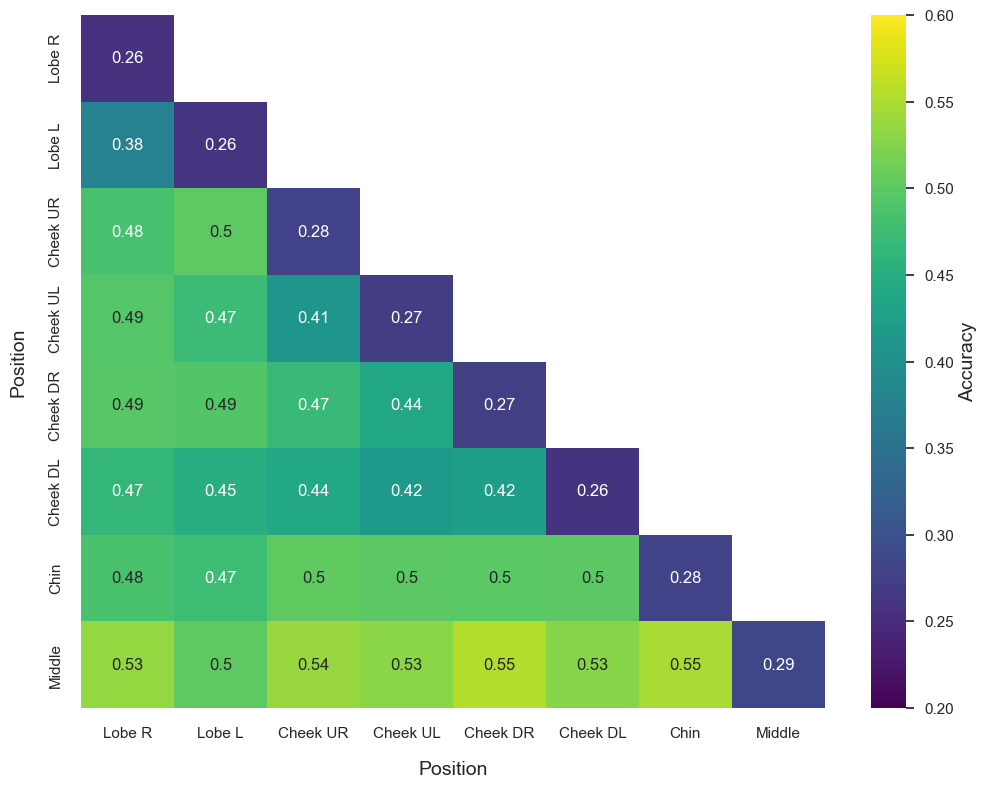

In [30]:
labels = ["Lobe R", "Lobe L", "Cheek UR", "Cheek UL", "Cheek DR", "Cheek DL", "Chin", "Middle"]

mask = np.zeros_like(el_matrix)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)

sns.set(font_scale=1)
palette = sns.color_palette("viridis", as_cmap=True)
ax = sns.heatmap(el_matrix, cmap=palette, annot=True, cbar_kws={'label': 'Accuracy'},
                xticklabels=labels, yticklabels=labels, mask=mask, vmin=0.2, vmax=0.6)

ax.set_facecolor('white')

plt.yticks(rotation=90, size=11)
plt.xticks(rotation=0, size=11)
    
ax.figure.axes[-1].yaxis.label.set_size(14)
plt.xlabel('Position', size=14, labelpad=15)
plt.ylabel('Position', size=14, labelpad=15)    
    
fig = plt.gcf()
fig.set_size_inches(12, 9)

# Basic emotions overall

The same analysis as above but with only "basic" emotions

In [31]:
basic_emotions = list(range(0, 7))

dfs_basic = []
for df in dfs:
    basic_df = df[df['emotion'].isin(basic_emotions)]
    dfs_basic.append(basic_df)

## Basic with ID

In [32]:
id_basic_matrix = np.zeros((10, 10))

In [33]:
id_was = []

for row in range(id_matrix.shape[0]):
    for col in range(id_matrix.shape[1]):
        
        if sorted([row, col]) in id_was:
            id_basic_matrix[row, col] = id_basic_matrix[col, row]
        else: 
            counter = 0
            df_train = pd.DataFrame(columns=columns_names)
            df_test = pd.DataFrame(columns=columns_names)

            for df in dfs_basic:
                if (counter == row) or (counter == col):
                    df_test = pd.concat([df_test, df], ignore_index=True)
                else:
                    df_train = pd.concat([df_train, df], ignore_index=True)
                counter += 1
            
            df_test = df_test.dropna(axis=1)
            df_train = df_train.dropna(axis=1)
            
            features_train = df_train.drop('emotion', axis=1)
            features_valid = df_test.drop('emotion', axis=1)
            target_train = df_train['emotion'].astype('int')
            target_valid = df_test['emotion'].astype('int')

            model = RandomForestClassifier(random_state=123)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            id_basic_matrix[row, col] = precision_score(target_valid, predicted_valid, average='micro')

            id_was.append([row, col])

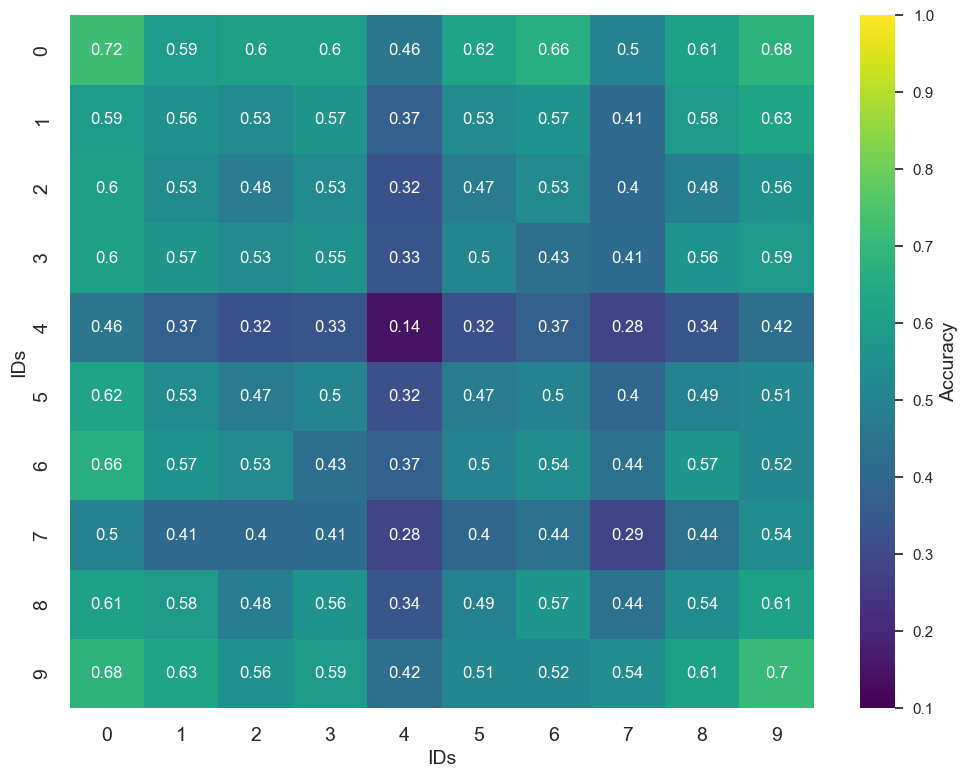

In [34]:
palette = sns.color_palette("viridis", as_cmap=True)
ax = sns.heatmap(id_basic_matrix, cmap='viridis', vmin=0.1, vmax=1, annot=True, cbar_kws={'label': 'Accuracy'})
ax.tick_params(axis='both', which='major', labelsize=14)
ax.figure.axes[-1].yaxis.label.set_size(14)
plt.xlabel('IDs', size=14)
plt.ylabel('IDs', size=14)

fig = plt.gcf()
fig.set_size_inches(12, 9)

In [35]:
print('mean:', id_basic_matrix.mean(), 'std:', id_basic_matrix.std())

mean: 0.4981904761904762 std: 0.10764017913058908


## Basic without ID

In [36]:
df_basic_overall = pd.concat(dfs_basic, ignore_index=True)

In [37]:
df_basic_overall = df_basic_overall.dropna(axis=1)

In [38]:
target = df_basic_overall['emotion']
features = df_basic_overall.drop('emotion', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=42)

In [39]:
model = RandomForestClassifier(random_state=5)
model = model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

In [40]:
print(precision_score(target_valid, predicted_valid, average='micro'))

0.8933333333333333


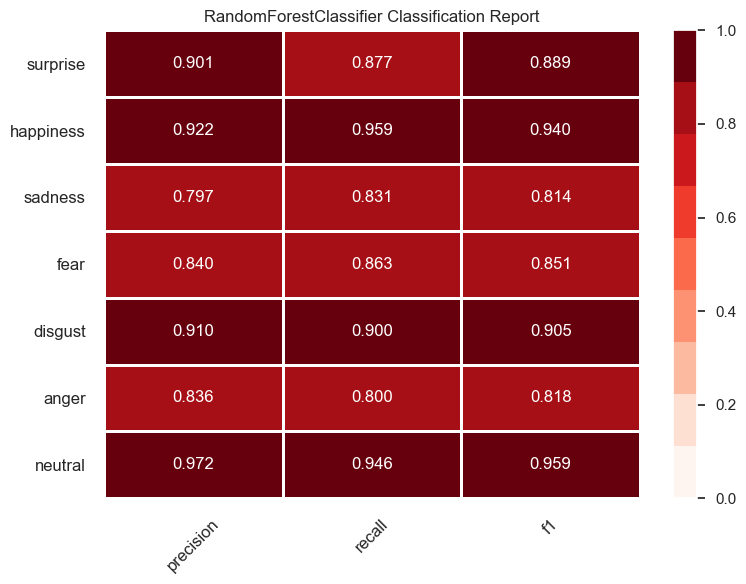

In [41]:
viz = ClassificationReport(RandomForestClassifier(random_state=17),
                           #support=True,
                           classes=emotions[:7],
                           fig=plt.figure(figsize=(8,6)), cmap='Reds')

viz.fit(features_train, target_train)

viz.score(features_valid, target_valid)

viz.show();

# Between emotions classification

Here we check how well a model can differentiate between pairs of expressions

In [42]:
between_emotions_matrix = np.zeros((12, 12))

In [43]:
id_was = []

for row in range(len(emotions)):
    for col in range(len(emotions)):
        
        if sorted([row, col]) in id_was:
            between_emotions_matrix[row, col] = between_emotions_matrix[col, row]
        else: 
            df_limited = df_overall[(df_overall['emotion'] == row) | (df_overall['emotion'] == col)]
            
            target = df_limited['emotion']
            features = df_limited.drop('emotion', axis=1)
            features_train, features_valid, target_train, target_valid = train_test_split(
                features, target, test_size=0.25, random_state=123)
        
            model = RandomForestClassifier(random_state=123)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            between_emotions_matrix[row, col] = precision_score(target_valid, predicted_valid, average='micro')

            id_was.append([row, col])

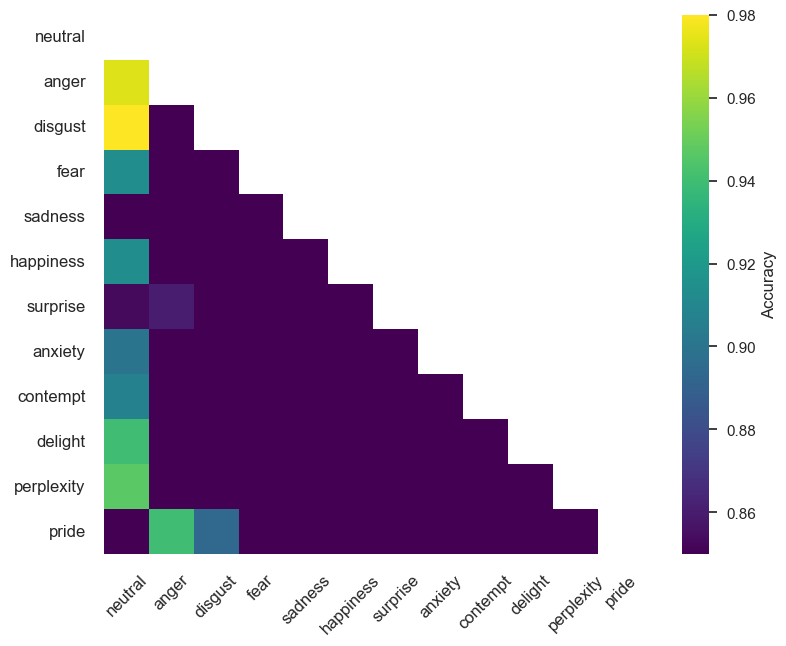

In [44]:
mask = np.zeros_like(between_emotions_matrix)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(between_emotions_matrix, mask=mask, square=True, cmap='viridis', vmin=0.85, cbar_kws={'label': 'Accuracy'})
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", 
             rotation_mode="anchor");
    
    ax.set_xticklabels(emotions, fontsize=12)
    ax.set_yticklabels(emotions, fontsize=12)

## Weights for topographies using Logistic Regression

Here we get weights of locations to plot topographies of expressions

In [45]:
weights = np.zeros((len(emotions), 32))

for row in range(1, len(emotions)):
    counter = 0
    df_train = pd.DataFrame(columns=columns_names)

    for df in dfs:
        
        labels = df['emotion'].astype('int')
        df = df.drop('emotion', axis=1)
        df = stats.zscore(df, axis=0)
        df['emotion'] = labels
        
        df_train = pd.concat([df_train, df], ignore_index=True)
        counter += 1
    
    df_train = df_train.dropna(axis=1)
    df_cropped = df_train[(df_train['emotion'] == 0) | (df_train['emotion'] == row)]
 
    features_train = df_cropped.drop('emotion', axis=1)
    target_train = df_cropped['emotion'].astype('int').replace(to_replace=row, value=1)

    model = LogisticRegression()
    model = model.fit(features_train, target_train)

    predicted_valid = model.predict(features_train)
    score = precision_score(predicted_valid, target_train)
    
    coefs = model.coef_[0]
    
    weights[row, :] = coefs

In [46]:
weights = weights[1:, :]

In [47]:
emotions_weights = []
for emot in range(weights.shape[0]):
    electrode = []
    for el in range(8):
        el1 = weights[emot, el]
        el2 = weights[emot, el+8]
        el3 = weights[emot, el+16]
        el4 = weights[emot, el+24]
        
        electrode.append(np.mean([el1, el2, el3, el4]))
    emotions_weights.append(electrode)

emotions_weights is a set of 11 expressions with 8 values in each corresponding to a mean weight in each channel (electrode)

To visualize topographies, I recommend using the MNE-python package (plots for the paper were made with it).